In [1]:


import pandas as pd
import pickle
import sqlite3
import os
import numpy as np
import sys
import gensim

import yellowbrick
import matplotlib.pyplot as plt

sys.path.append(r'C:\Users\aspit\Git\MHDLab-Projects\Energy Storage\nlp_utils')

data_folder = r'C:\Users\aspit\Git\MHDLab-Projects\NLP_MHD\data'

con = sqlite3.connect(os.path.join(data_folder, 'seamsnlp.db'))
cursor = con.cursor()

df = pd.read_sql_query("SELECT * FROM texts", con, index_col='ID')
df_metadata = pd.read_sql_query("SELECT * FROM metadata", con, index_col='ID')
df_tsne = pd.read_sql_query("SELECT * FROM Kmeans_tsne", con, index_col='ID')


df = pd.concat([df,df_metadata, df_tsne], axis=1).dropna(subset=['processed_text'])

df = df[df['Session Name'] != 'Intro Materials'].dropna(subset=['Session Name'])

# df = df.sample(500)

texts = df['processed_text'].values



In [2]:

texts = [t.split() for t in texts]

bigram = gensim.models.Phrases(texts, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

texts = [bigram_mod[doc] for doc in texts]

texts = [" ".join(t) for t in texts]

n_topics = 20
alpha=0.05
eta=0.05



In [3]:

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=None, min_df=5, max_df = 0.8, ngram_range=(1,2))
X = vectorizer.fit_transform(texts)

lda_sklearn = LatentDirichletAllocation(
    n_components=n_topics,
    doc_topic_prior=alpha,
    topic_word_prior=eta,
    random_state=1
    )

X_topics = lda_sklearn.fit_transform(X)

feature_names = vectorizer.get_feature_names()

top_n = 15

topic_keywords = []
for idx, topic in enumerate(lda_sklearn.components_):
    #topic.argsort gives indicies of of top_n words associated with topic 
    # topic_keywords.append([(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])
    topic_keywords.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
topic_keywords = pd.Series(topic_keywords, index=range(n_topics))
topic_keywords.name = 'Topic Keywords'
topic_keywords = topic_keywords.apply(", ".join)

print(topic_keywords)

0     liquid, metal, cycle, efficiency, liquid metal...
1     velocity, model, wall, field, dimensional, tur...
2     electron, measurement, coil, plasma, density, ...
3     channel, plasma, generator, layer, pressure, m...
4     electrode, material, surface, slag, anode, cop...
5     generator, channel, field, load, pressure, wal...
6     current, electrode, voltage, channel, wall, ca...
7     field, electron, plasma, magnetic, current, ma...
8     current, pressure, frequency, thruster, fluctu...
9     plant, coal, heat, steam, seed, air, cost, des...
10    disk, generator, seed, pressure, enthalpy_extr...
11    slag, coal, heat, tube, air, material, ash, po...
12    electron, scale, density, corrosion, alloy, ra...
13    combustor, coal, stage, slag, channel, design,...
14    slag, cathode, wall, voltage, gap, anode, elem...
15    magnet, design, field, coil, channel, conducto...
16    particle, measurement, combustion, size, measu...
17    hall, generator, electrode, current, volta

<AxesSubplot:>

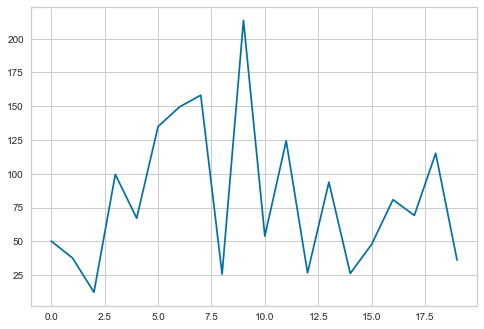

In [4]:
probs_sklearn = pd.DataFrame(X_topics)
probs_sklearn.index = df.index
probs_sklearn.sum().plot()


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

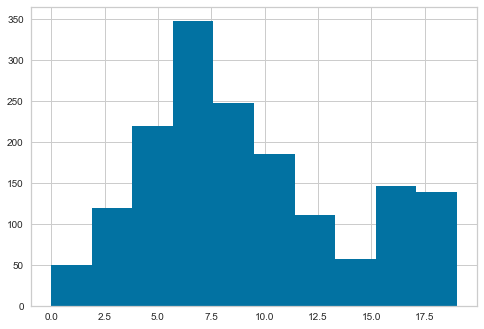

In [48]:

top_doc_topics_sklearn = probs_sklearn.idxmax(axis=1)


top_doc_topics_sklearn.name = 'top_doc_topics'
top_doc_topics_sklearn.hist()


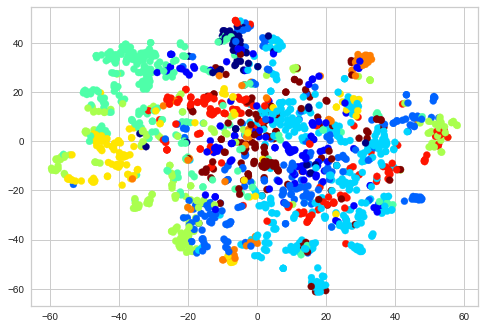

In [6]:

# Create the visualizer and draw the vectors
tsne_x =df['tsne_x']
tsne_y =df['tsne_y']

plt.scatter(tsne_x, tsne_y, c=top_doc_topics_sklearn, cmap=plt.cm.get_cmap("jet",10))


In [49]:
x_std = pd.concat([tsne_x, top_doc_topics_sklearn], axis=1).groupby('top_doc_topics').std().values
y_std = pd.concat([tsne_y, top_doc_topics_sklearn], axis=1).groupby('top_doc_topics').std().values

std_tot = x_std**2 + y_std**2
np.mean(std_tot)

C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1323.5028194967267

In [47]:

import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

vis = pyLDAvis.sklearn.prepare(lda_sklearn, X, vectorizer, sort_topics=False)

# outpath = os.path.join(r'C:\Users\aspit\Git\MHDLab-Projects\NLP_MHD\analysis\compare_gensim_sklearn', 'lda_sklearn.html')
# pyLDAvis.save_html(vis,outpath )



C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:

texts = [t.split() for t in texts]
id2word = gensim.corpora.Dictionary(texts)
data_words = [id2word.doc2bow(doc) for doc in texts]

lda_gensim = gensim.models.LdaModel(
                                data_words,
                                num_topics=n_topics,
                                id2word=id2word,
                                passes = 20,
                                alpha=eta,
                                eta=eta
)


lda_gensim.print_topics()



C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.033*"generator" + 0.031*"magnetohydrodynamic" + 0.027*"channel" + 0.014*"power" + 0.013*"load" + 0.012*"flow" + 0.011*"current" + 0.010*"electrical" + 0.009*"ee" + 0.008*"equation"'),
 (1,
  '0.064*"arc" + 0.029*"cathode" + 0.022*"gap" + 0.020*"slag" + 0.018*"current" + 0.016*"voltage" + 0.011*"high" + 0.010*"anode" + 0.008*"spot" + 0.008*"heat"'),
 (2,
  '0.030*"magnet" + 0.022*"coil" + 0.020*"field" + 0.018*"design" + 0.013*"current" + 0.011*"magnetic" + 0.011*"magnetohydrodynamic" + 0.010*"conductor" + 0.010*"power" + 0.008*"winding"'),
 (3,
  '0.079*"electrode" + 0.019*"current" + 0.017*"conductivity" + 0.017*"voltage" + 0.015*"generator" + 0.014*"oxide" + 0.011*"magnetohydrodynamic" + 0.010*"circuit" + 0.009*"pair" + 0.008*"channel"'),
 (4,
  '0.048*"electron" + 0.026*"plasma" + 0.024*"temperature" + 0.019*"density" + 0.017*"energy" + 0.015*"gas" + 0.012*"ion" + 0.011*"ionization" + 0.008*"equilibrium" + 0.008*"rate"'),
 (5,
  '0.025*"field" + 0.020*"current" + 0.018*"ac

In [9]:
gensim_topiclist = list(lda_gensim.get_document_topics(data_words, minimum_probability=0))



C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:

df_topics_gensim = pd.DataFrame(index=gensim_topiclist[0])

probs = []

for doc in gensim_topiclist:
    doc_topics = list(zip(*doc))
    top_nums, prob = doc_topics
    probs.append(prob)

probs_gensim = pd.DataFrame(probs)

probs_gensim.index = df.index

C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

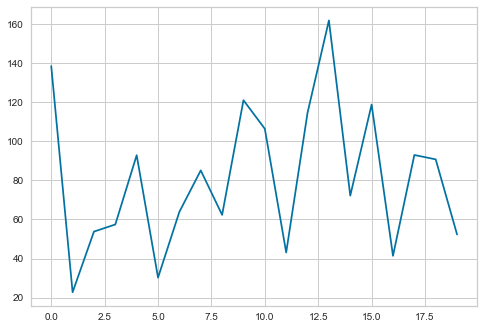

In [29]:

probs_gensim.sum().plot()


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

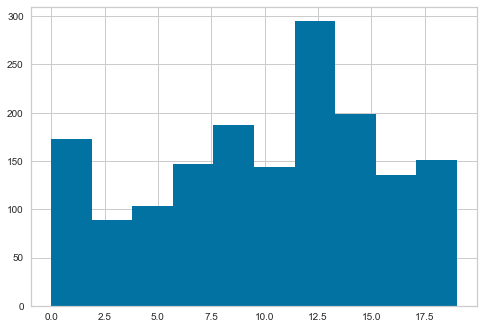

In [30]:

top_doc_topics_gensim = probs_gensim.idxmax(axis=1)
top_doc_topics_gensim.name = 'top_doc_topics'
top_doc_topics_gensim.hist()


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


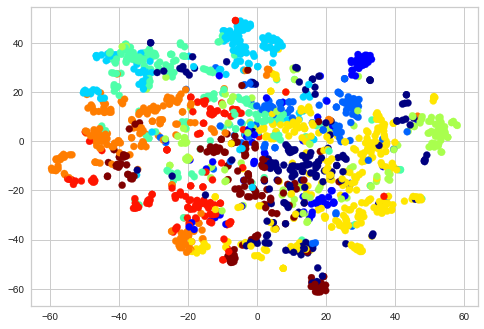

In [44]:

# Create the visualizer and draw the vectors
tsne_x =df['tsne_x']
tsne_y =df['tsne_y']

plt.scatter(tsne_x, tsne_y, c=top_doc_topics_gensim, cmap=plt.cm.get_cmap("jet",10))



What is the average spread of each cluster

In [45]:
x_std = pd.concat([tsne_x, top_doc_topics_gensim], axis=1).groupby('top_doc_topics').std().values
y_std = pd.concat([tsne_y, top_doc_topics_gensim], axis=1).groupby('top_doc_topics').std().values

std_tot = x_std**2 + y_std**2
np.mean(std_tot)

C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


423.89219068246973

In [14]:
import pyLDAvis
import pyLDAvis.gensim

vis = pyLDAvis.gensim.prepare(lda_gensim,data_words, id2word, sort_topics=False)

vis
# outpath = os.path.join(r'C:\Users\aspit\Git\MHDLab-Projects\NLP_MHD\analysis\compare_gensim_sklearn', 'lda_gensim.html')
# pyLDAvis.save_html(vis,outpath )

C:\Users\aspit\AppData\Roaming\Python\Python37\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
0      0.051048 -0.039095       1        1  8.499897
1      0.046321 -0.104124       2        1  1.378129
2     -0.052196 -0.087404       3        1  3.010708
3      0.071889 -0.084983       4        1  2.975982
4      0.119837  0.113233       5        1  4.861174
5      0.079829 -0.035875       6        1  1.808353
6     -0.226391 -0.028092       7        1  4.347813
7      0.010533 -0.012253       8        1  4.150148
8      0.055654  0.089669       9        1  3.746889
9     -0.164015  0.035806      10        1  8.288070
10     0.070754 -0.057766      11        1  6.109709
11    -0.040521  0.100629      12        1  3.482393
12     0.118520 -0.068859      13        1  7.203118
13     0.142174  0.014825      14        1  8.508411
14    -0.029673  0.085163      15        1  5.314439
15    -0.115322  0.084574      16        1  8.199172
16     0.070085  0.172498      17        1  2.625237
17    -0.112732 -0.013294      18        1  5.963216
18    -0.028716 -0.151768      19        1  6.941782
19    -0.067079 -0.012883      20        1  2.585361, topic_info=           Term          Freq         Total Category  logprob  loglift
1962  electrode  19892.000000  19892.000000  Default  30.0000  30.0000
53      current  24165.000000  24165.000000  Default  29.0000  29.0000
85     electron   7188.000000   7188.000000  Default  28.0000  28.0000
1322  generator  23394.000000  23394.000000  Default  27.0000  27.0000
2872      plant   8829.000000   8829.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
1962  electrode    422.979021  19892.496508  Topic20  -5.0538  -0.1955
120         gas    414.088625  20959.295353  Topic20  -5.0750  -0.2690
545        heat    368.200472  12967.304755  Topic20  -5.1925   0.0937
2618       seed    361.779002  11264.190466  Topic20  -5.2101   0.2170
242      result    333.833374  14816.399661  Topic20  -5.2905  -0.1375

[1714 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
17700     10  0.089570  27th_aerospace
17700     12  0.806126  27th_aerospace
11979      1  0.923774            34th
11979      4  0.041990            34th
4454       1  0.085587             abc
...      ...       ...             ...
3212      13  0.033774        zirconia
3212      16  0.037151        zirconia
3212      18  0.486344        zirconia
3212      19  0.020264        zirconia
3212      20  0.016887        zirconia

[9191 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])